# SECTION 3.3: KMULTI

In [1]:
import sys
import pickle
from numpy import *

sys.path.insert(0, '/cs/sci/freundlich/CUSPCORE/Analysis/Preparing')
sys.path.insert(0, '/cs/sci/freundlich/CUSPCORE/Analysis/Formatting')
sys.path.insert(0, '/cs/sci/freundlich/CUSPCORE/Analysis/Model')

import treal_functions
import slopes_functions
import prepare_functions
import cuspcore_aux
import cuspcore_plots
import evolving
import fitting as fit
from cuspcore_aux import *
from cuspcore_plots import *
from evolving import *

reload(cuspcore_aux)
reload(cuspcore_plots)
reload(evolving)
reload(fit)
reload(treal_functions)
reload(slopes_functions)
reload(prepare_functions)

sim = ['g1.08e11'][0]
directory='/cs/sci/freundlich/CUSPCORE/Analysis/DATA/'
directory='/cs/sci/freundlich/CUSPCORE/Michael/' 

with open(directory+'NIHAO-%s.pickle'%sim[1:]) as f:
    gl = pickle.load(f)
 
gl = slopes_functions.derive_slopes(gl,polyorder=3,sigma = 21,mode= 'interp',double_smooth=False,rlim=[-2.,0.],use_fangzhou_Rvir=True)    
gl = prepare_functions.define_brho(gl,polyorder=3,sigma = 21,mode= 'interp',double_smooth=False,rlim=[-2.,0.],use_fangzhou_Rvir=True)
treal=treal_functions.load_or_create_gl(sim)

fitrange=prepare_functions.get_fitrange(gl)
gl=prepare_functions.reduce_range_gl(gl,fitrange)
treal=prepare_functions.reduce_range_Treal(treal,fitrange)

a_array=[]

for (i,ss) in zip(range(size(gl)),gl):
    a_array.append(ss['a'])           

a_array=array(a_array)

ok_fangzhou,r12_fangzhou,rvir_fangzhou,mvir_fangzhou=get_fangzhou_radii(sim,a_array,get_all=False)
gl=fit.do_fits(gl,rvir_fangzhou,mvir_fangzhou,1.,0.01,2.,components=['d'])
print 'Done'

/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


 
Loading existing file Treal-1.08e11.pickle
Reducing the range of gl
Reducing the range of Treal
Done


In [2]:
# FIGURE PROPERTIES

fontsize=20
legendsize=fontsize
linewidth=2
linesize=5
ticksize=fontsize-4
figsize=(8,12)

rcParams['axes.linewidth'] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

rcParams['figure.subplot.left']=0.15
rcParams['figure.subplot.right']=0.9
rcParams['figure.subplot.bottom']=0.15
rcParams['figure.subplot.top']=0.9
rcParams['figure.subplot.wspace']=0.1
rcParams['figure.subplot.hspace']=0.1


In [3]:
def sigmar2_Mratio(x,Mv,Rv,c,a,Mratio=1.,n=0.):
    """
    radial velocity dispersion squared of a Dekel+17 halo at radius r --
    for isotropic velocity distribution, beta=0
    
    where we assume Mtot/Mdm=Mratio*(r/Rvir)**-n
        
    where:
        x: r/rs (scalar)
        Mv: halo mass [Msun] (scalar)
        c: concentration (scalar)
        alpha: inner density slope (scalar)
        z: redshift (scalar, default=0.)    
    """
    Vv_sqr = G * Mv / Rv
    X = prf.chi(x)
    u = 4*(1.-a)-2*n
    return 2.*Vv_sqr *c/prf.g(c,a) * x**a*(1.+x**0.5)**(2.*(3.5-a))*Mratio*c**n \
        * (prf.Binc(u,9+2*n,1)-prf.Binc(u,9+2*n,X))

In [4]:
# FIT Mtot/Mdm at every snapshot

reload(treal_functions)
import profiles as prf
reload(prf)

from matplotlib.pylab import *
G = 4.499753324353496e-06 # gravitational constant [kpc^3 Gyr^-2 Msun^-1]

rlim=array([-2.,0.])
component='d'
tmin=3.

parsec=3.085677581e16 #m
year=3.1557600e7 #s
kms_to_kpcGyr=1/parsec*year*1e9


/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


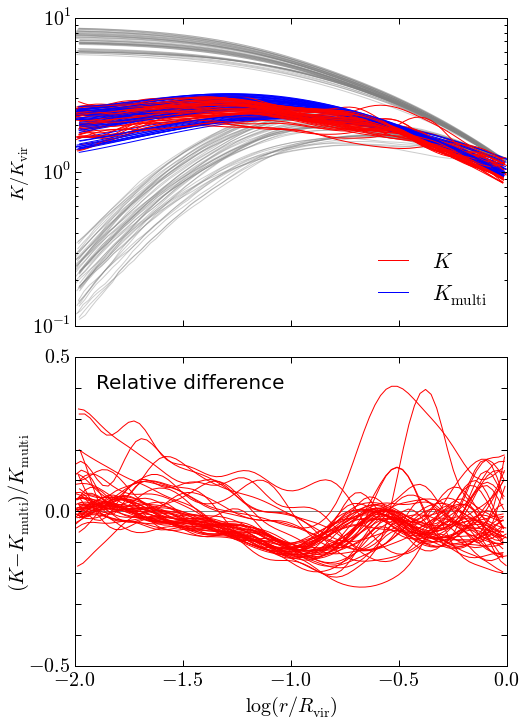

In [5]:

figure(figsize=figsize)

counter=0

ax1=subplot(211)

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']

    # T from hydrostatic equilibrum (sigmar)
    p=ss[component]['lsfit_brho_b2_g3_unconstrained']['p']
    (ci, ai, bi, gi, Rviri, Mviri) = p
    x=ci*r/Rviri
    
    # T as 3/2alpha Vc^2
    vc2=G*ss[component]['Mall']/ss[component]['r']
    T_virial=0.5*vc2/Kvir

    # T real
    T_real=treal[i][2]/Kvir

    #T_virial2 from 
    Utot=treal_functions.Utot(ss,r)
    TU=-0.5*Utot/Kvir
    
    logr=log10(r/Rvir)
    if t>tmin:
        if counter==0:
            plot(logr,TU,color='gray',linestyle='-',lw=1,alpha=0.4)#,label=r'$\rm K_{virial} = -U(r)/2$')
            plot(logr,T_virial,color='gray',linestyle='-',lw=1,alpha=0.4)#,label=r'$\rm K_{Dutton}=GM(r)/2r$')
        else:
            plot(logr,TU,color='gray',lw=1,alpha=0.4)
            plot(logr,T_virial,color='gray',linestyle='-',lw=1,alpha=0.4)

        counter=counter+1
        
counter=0
for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']
    
    logr=log10(r/Rvir)
    
    if t>tmin:
        # Define Mtot/Mdm
        rmin=max(ss['d']['r'][0],ss['all']['r'][0])
        Md = ss['d']['M'][where(ss['d']['r']>rmin)]
        Ma = ss['all']['M'][where(ss['d']['r']>rmin)]
        rr=r[where(ss['d']['r']>rmin)]
        Mratio=Ma/Md

        slope, intercept, r_value, p_value, std_err = stats.linregress(log10(rr/Rvir),log10(Mratio))
        Mratio0=10**intercept
        n=-slope

        # T from hydrostatic equilibrum (sigmar)
        p=ss[component]['lsfit_brho_b2_g3_unconstrained']['p']
        (ci, ai, bi, gi, Rviri, Mviri) = p
        x=ci*r/Rviri
        Tdekel=prf.K_Mratio(x,Mviri,Rviri,ci,ai,Mratio0,n)/Kvir

        # T as 3/2alpha Vc^2
        vc2=G*ss[component]['Mall']/ss[component]['r']
        T_virial=0.5*vc2/Kvir

        # T real
        T_real=treal[i][2]/Kvir

        #T_virial2 from 
        Utot=treal_functions.Utot(ss,r)
        TU=-0.5*Utot/Kvir
    
        if counter==0:
            plot(logr,T_real,color='r',label=r'$K$',lw=1,alpha=1)
            plot(logr,Tdekel,color='b',linestyle='-',label=r'$K_{\rm multi}$',lw=1,alpha=1)
        else:
            plot(logr,T_real,color='r',lw=1,alpha=1)
            plot(logr,Tdekel,color='b',linestyle='-',lw=1,alpha=1)
            
        counter=counter+1
     

yscale('log')
ylabel(r'$K/K_{\rm vir}$')#,fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$10^{%i}$'%int(log10(item)) for item in logspace(-1,1,3)]
yticks(logspace(-1,1,3),yticknames,visible=True)

ylim(0.1,10)
xlim(rlim)

legend(frameon=False,loc='lower right')

##################################################################################################

ax2=subplot(212, sharex=ax1)

axhline(0,color='gray')
counter=0
DT_all=[]
DT_mean=[]
DT_rms=[]

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']

    logr=log10(r/Rvir)
    
    if t>tmin:
        # Define Mtot/Mdm
        rmin=max(ss['d']['r'][0],ss['all']['r'][0])
        Md = ss['d']['M'][where(ss['d']['r']>rmin)]
        Ma = ss['all']['M'][where(ss['d']['r']>rmin)]
        rr=r[where(ss['d']['r']>rmin)]
        Mratio=Ma/Md

        slope, intercept, r_value, p_value, std_err = stats.linregress(log10(rr/Rvir),log10(Mratio))
        Mratio0=10**intercept
        n=-slope

        # T from hydrostatic equilibrum (sigmar)
        p=ss[component]['lsfit_brho_b2_g3_unconstrained']['p']
        (ci, ai, bi, gi, Rviri, Mviri) = p
        x=ci*r/Rviri
        sigmar2=sigmar2_Mratio(x,Mviri,Rviri,ci,ai,Mratio0,n)
        Tdekel=1.5*sigmar2/Kvir

        # T as 3/2alpha Vc^2
        vc2=G*ss[component]['Mall']/ss[component]['r']
        T_virial=0.5*vc2/Kvir

        # T real
        T_real=treal[i][2]/Kvir

        #T_virial2 from 
        DT=(T_real-Tdekel)/Tdekel

        rrange=where((logr>rlim[0])&(logr<rlim[1]))
        DT_all.append(array(DT[rrange]))
        DT_mean.append(mean(array_nonan(array(DT[rrange]))))
        DT_rms.append(sqrt(mean(array_nonan(array(DT[rrange])**2))))

        plot(logr,(DT),color='r',linestyle='-',lw=1,alpha=1)

xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-K_{\rm multi})/K_{\rm multi}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper left')

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$%.1f$'%log10(item) for item in logspace(-1,1,5)]
yticks(log10(logspace(-1,1,5)),yticknames,visible=True)
yticknames=['$%.1f$'%log10(item) for item in logspace(-0.5,0.5,11)]
yticknames=['$-0.5$', ' ', ' ', ' ', ' ', '$0.0$', ' ', ' ', ' ', ' ','$0.5$']
yticks(log10(logspace(-0.5,0.5,11)),yticknames,visible=True)

ylim(-.52,.52)
xlim(rlim)
ylim(-.5,.5)


ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.set_label_coords(-0.1,0.5)
ax2.yaxis.set_label_coords(-0.1,0.5)


In [7]:
print 'mean difference: ', mean(array_nonan(array(DT_mean)))
print 'mean RMS difference: ', mean(array_nonan(array(DT_rms)))

mean difference:  -0.0319683154725
mean RMS difference:  0.0822457208645


In [8]:
abscisse=log10(logspace(-2,0,1000))

K_curve=[]
Kvirial_curve=[]
Kin_curve=[]
Kmulti_curve=[]
DK_curve=[]

for (ss, i) in zip(gl, range(size(gl))):
    
    r= ss[component]['r']
    Rvir=ss['Rvir']
    Mvir=ss[component]['Mvir']
    Kvir=0.5*G*Mvir/Rvir
    logr=log10(ss[component]['r']/ss['Rvir'])
    t=ss['t']

    # T from hydrostatic equilibrum (sigmar)
    p=ss[component]['lsfit_brho_b2_g3_unconstrained']['p']
    (ci, ai, bi, gi, Rviri, Mviri) = p
    x=ci*r/Rviri

    # T as 3/2alpha Vc^2
    vc2=G*ss[component]['Mall']/ss[component]['r']
    T_virial=0.5*vc2/Kvir

    # T real
    T_real=treal[i][2]/Kvir

    #T_virial2 from 
    Utot=treal_functions.Utot(ss,r)
    TU=-0.5*Utot/Kvir
    
    if t>tmin:
        Kvirial_curve.append(list(interp(abscisse,logr,TU,left=nan,right=nan)))
        Kin_curve.append(list(interp(abscisse,logr,T_virial,left=nan,right=nan)))
        
        rmin=max(ss['d']['r'][0],ss['all']['r'][0])
        Md = ss['d']['M'][where(ss['d']['r']>rmin)]
        Ma = ss['all']['M'][where(ss['d']['r']>rmin)]
        rr=r[where(ss['d']['r']>rmin)]
        Mratio=Ma/Md

        slope, intercept, r_value, p_value, std_err = stats.linregress(log10(rr/Rvir),log10(Mratio))
        Mratio0=10**intercept
        n=-slope

        # T from hydrostatic equilibrum (sigmar)
        p=ss[component]['lsfit_brho_b2_g3_unconstrained']['p']
        (ci, ai, bi, gi, Rviri, Mviri) = p
        x=ci*r/Rviri
        
        Tdekel=prf.K_Mratio(x,Mviri,Rviri,ci,ai,Mratio0,n)/Kvir

        # T as 3/2alpha Vc^2
        vc2=G*ss[component]['Mall']/ss[component]['r']
        T_virial=0.5*vc2/Kvir

        # T real
        T_real=treal[i][2]/Kvir

        #T_virial2 from 
        Utot=treal_functions.Utot(ss,r)
        TU=-0.5*Utot/Kvir
        
        DT=(T_real-Tdekel)/Tdekel
    
        K_curve.append(list(interp(abscisse,logr,T_real,left=nan,right=nan)))
        Kmulti_curve.append(list(interp(abscisse,logr,Tdekel,left=nan,right=nan)))
        DK_curve.append(list(interp(abscisse,logr,DT,left=nan,right=nan)))
        
K_curve=array(K_curve)
Kvirial_curve=array(Kvirial_curve)
Kin_curve=array(Kin_curve)
Kmulti_curve=array(Kmulti_curve)
DK_curve=array(DK_curve)

K_min=nan*ones_like(abscisse)
K_max=nan*ones_like(abscisse)
K_med=nan*ones_like(abscisse)
Kvirial_min=nan*ones_like(abscisse)
Kvirial_max=nan*ones_like(abscisse)
Kvirial_med=nan*ones_like(abscisse)
Kin_min=nan*ones_like(abscisse)
Kin_max=nan*ones_like(abscisse)
Kin_med=nan*ones_like(abscisse)
Kmulti_min=nan*ones_like(abscisse)
Kmulti_max=nan*ones_like(abscisse)
Kmulti_med=nan*ones_like(abscisse)
DK_min=nan*ones_like(abscisse)
DK_max=nan*ones_like(abscisse)
DK_med=nan*ones_like(abscisse)
DK_rms=nan*ones_like(abscisse)
for i in range(size(abscisse)):
    try:
        K_min[i]=amin(array_nonan(K_curve[:,i]))
        K_max[i]=amax(array_nonan(K_curve[:,i]))
        K_med[i]=median((K_curve[:,i]))
    except:
        continue
    try:
        Kvirial_min[i]=amin(array_nonan(Kvirial_curve[:,i]))
        Kvirial_max[i]=amax(array_nonan(Kvirial_curve[:,i]))
        Kvirial_med[i]=median((Kvirial_curve[:,i]))
    except:
        continue    
    try:
        Kin_min[i]=amin(array_nonan(Kin_curve[:,i]))
        Kin_max[i]=amax(array_nonan(Kin_curve[:,i]))
        Kin_med[i]=median((Kin_curve[:,i]))
    except:
        continue        
    try:
        Kmulti_min[i]=amin(array_nonan(Kmulti_curve[:,i]))
        Kmulti_max[i]=amax(array_nonan(Kmulti_curve[:,i]))
        Kmulti_med[i]=median((Kmulti_curve[:,i]))
    except:
        continue
    try:
        DK_min[i]=amin(array_nonan(DK_curve[:,i]))
        DK_max[i]=amax(array_nonan(DK_curve[:,i]))
        DK_med[i]=median((DK_curve[:,i]))
        DK_rms[i]=std(array_nonan(DK_curve[:,i]))
    except:
        continue


/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


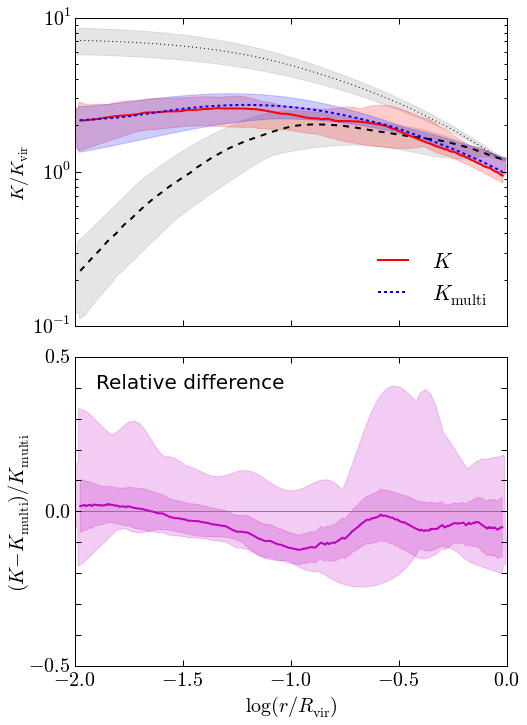

In [9]:
# FIT Mtot/Mdm at every snapshot

alpha_fill=0.2

figure(figsize=figsize)

ax1=subplot(211)

fill_between(abscisse,Kin_min,Kin_max,color='gray',alpha=alpha_fill)
plot(abscisse,Kin_med,color='k',ls='--',lw=2)#,label=r'$K_{\rm isolated}$')

fill_between(abscisse,Kvirial_min,Kvirial_max,color='gray',alpha=alpha_fill)
plot(abscisse,Kvirial_med,color='k',ls=':')#,lw=2,label=r'$K_{\rm virial}$')

fill_between(abscisse,K_min,K_max,color='r',alpha=alpha_fill)
plot(abscisse,K_med,lw=2,color='r',label=r'$K$')

fill_between(abscisse,Kmulti_min,Kmulti_max,color='b',alpha=alpha_fill)
plot(abscisse,Kmulti_med,color='b',ls='dashed',dashes=(3,3),lw=2,label=r'$K_{\rm multi}$')

yscale('log')

ylabel(r'$K/K_{\rm vir}$')#,fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$10^{%i}$'%int(log10(item)) for item in logspace(-1,1,3)]
yticks(logspace(-1,1,3),yticknames,visible=True)

ylim(0.1,10)
xlim(rlim)

legend(frameon=False,loc='lower right')

##################################################################################################

ax2=subplot(212, sharex=ax1)

axhline(0,color='gray')

fill_between(abscisse,DK_min,DK_max,color='m',alpha=alpha_fill)
plot(abscisse,DK_med,lw=2,color='m')#,label=r'$K$')
fill_between(abscisse,DK_med-DK_rms,DK_med+DK_rms,color='m',alpha=alpha_fill)

xlabel(r'$\log(r/R_{\rm vir})$',fontsize=fontsize)
ylabel(r'$(K-K_{\rm multi})/K_{\rm multi}$',fontsize=fontsize) #$\rm [kpc^2 Gyr^{-2}]$
legend(fontsize=legendsize,frameon=False,loc='upper left')

xticknames=['$%.1f$'%log10(item) for item in logspace(-2,0,5)]
xticks(log10(logspace(-2,0,5)),xticknames,visible=True)

yticknames=['$%.1f$'%log10(item) for item in logspace(-1,1,5)]
yticks(log10(logspace(-1,1,5)),yticknames,visible=True)

yticknames=['$%.1f$'%log10(item) for item in logspace(-0.5,0.5,11)]
yticknames=['$-0.5$', ' ', ' ', ' ', ' ', '$0.0$', ' ', ' ', ' ', ' ','$0.5$']
yticks(log10(logspace(-0.5,0.5,11)),yticknames,visible=True)

ylim(-.52,.52)
xlim(rlim)


ylim(-.5,.5)


ax=gca()
ax.text(0.05,0.9,r'Relative difference',fontsize=fontsize,transform=ax.transAxes)

setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.set_label_coords(-0.1,0.5)
ax2.yaxis.set_label_coords(-0.1,0.5)